# Workload Characterization

## Introduction

### Import relevant modules

In [8]:
# Data Analysis
import pandas as pd

# Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing

# Utilities
import numpy as np
# from tqdm import tnrange
import pickle
import os
from tqdm import tqdm_notebook as tqdmn
# import warnings

In [9]:
%config InlineBackend.figure_format = 'retina'

# High level parameters

## Read data

In [10]:
df_high = pd.read_csv('WC_report_client.csv')
df_high.head()

,timeStamp,elapsed,label,responseCode,responseMessage,threadName,dataType,success,failureMessage,bytes,sentBytes,grpThreads,allThreads,URL,Latency,IdleTime,Connect
0,1609346383111,48,HTTP Request - Wikipedia Home,200,OK,Thread Group - Slow 1-1,text,True,NaN,78492,134,1,3,http://192.168.56.101/WikipediaHome.html,45,0,30
1,1609346383111,48,HTTP Request - Reddit Home,200,OK,Thread Group - Fast 2-1,text,True,NaN,911062,131,1,3,http://192.168.56.101/RedditHome.html,45,0,30
2,1609346383111,48,HTTP Request - Repubblica Home,200,OK,Thread Group - Home 3-1,text,True,NaN,387753,135,1,3,http://192.168.56.101/RepubblicaHome.html,45,0,30
3,1609346383422,2,HTTP Request - Wikipedia Home,200,OK,Thread Group - Fast 2-2,text,True,NaN,78492,134,2,6,http://192.168.56.101/WikipediaHome.html,2,0,1
4,1609346383469,9,HTTP Request - Reddit Home,200,OK,Thread Group - Slow 1-2,text,True,NaN,911062,131,2,6,http://192.168.56.101/RedditHome.html,2,0,1


In [11]:
print('The dataset contains', df_high.shape[1], 'columns and', df_high.shape[0], 'rows')

The dataset contains 17 columns and 6338 rows


In [12]:
df_high['success'].all()

True

In [13]:
df_high.loc[df_high['label'].str.contains('Wikipedia'), 'resourceType'] = 'small'
df_high.loc[df_high['label'].str.contains('Repubblica'), 'resourceType'] = 'medium'
df_high.loc[df_high['label'].str.contains('Reddit'), 'resourceType'] = 'large'

df_high.loc[df_high['threadName'].str.contains('Slow'), 'threadType'] = 'slow'
df_high.loc[df_high['threadName'].str.contains('Fast'), 'threadType'] = 'fast'
df_high.loc[df_high['threadName'].str.contains('Home'), 'threadType'] = 'home'

df_high.head()

,timeStamp,elapsed,label,responseCode,responseMessage,threadName,dataType,success,failureMessage,bytes,sentBytes,grpThreads,allThreads,URL,Latency,IdleTime,Connect,resourceType,threadType
0,1609346383111,48,HTTP Request - Wikipedia Home,200,OK,Thread Group - Slow 1-1,text,True,NaN,78492,134,1,3,http://192.168.56.101/WikipediaHome.html,45,0,30,small,slow
1,1609346383111,48,HTTP Request - Reddit Home,200,OK,Thread Group - Fast 2-1,text,True,NaN,911062,131,1,3,http://192.168.56.101/RedditHome.html,45,0,30,large,fast
2,1609346383111,48,HTTP Request - Repubblica Home,200,OK,Thread Group - Home 3-1,text,True,NaN,387753,135,1,3,http://192.168.56.101/RepubblicaHome.html,45,0,30,medium,home
3,1609346383422,2,HTTP Request - Wikipedia Home,200,OK,Thread Group - Fast 2-2,text,True,NaN,78492,134,2,6,http://192.168.56.101/WikipediaHome.html,2,0,1,small,fast
4,1609346383469,9,HTTP Request - Reddit Home,200,OK,Thread Group - Slow 1-2,text,True,NaN,911062,131,2,6,http://192.168.56.101/RedditHome.html,2,0,1,large,slow


## Data analysis

In [14]:
df_high.describe()

,timeStamp,elapsed,responseCode,failureMessage,bytes,sentBytes,grpThreads,allThreads,Latency,IdleTime,Connect
count,6.338000e+03,6338.000000,6338.0,0.0,6338.000000,6338.000000,6338.000000,6338.000000,6338.000000,6338.0,6338.000000
mean,1.609347e+12,8.330388,200.0,NaN,453655.431209,133.297570,37.579363,97.528085,2.586936,0.0,0.502209
std,8.455378e+04,8.139487,0.0,NaN,334132.008234,1.707357,6.852841,11.239369,3.967968,0.0,1.427014
min,1.609346e+12,0.000000,200.0,NaN,78491.000000,131.000000,1.000000,1.000000,0.000000,0.0,0.000000
25%,1.609346e+12,3.000000,200.0,NaN,93219.000000,131.000000,40.000000,100.000000,1.000000,0.0,0.000000
50%,1.609347e+12,6.000000,200.0,NaN,387752.000000,134.000000,40.000000,100.000000,1.000000,0.0,0.000000
75%,1.609347e+12,10.000000,200.0,NaN,857514.000000,135.000000,40.000000,100.000000,3.000000,0.0,1.000000
max,1.609347e+12,84.000000,200.0,NaN,911062.000000,135.000000,40.000000,100.000000,73.000000,0.0,30.000000


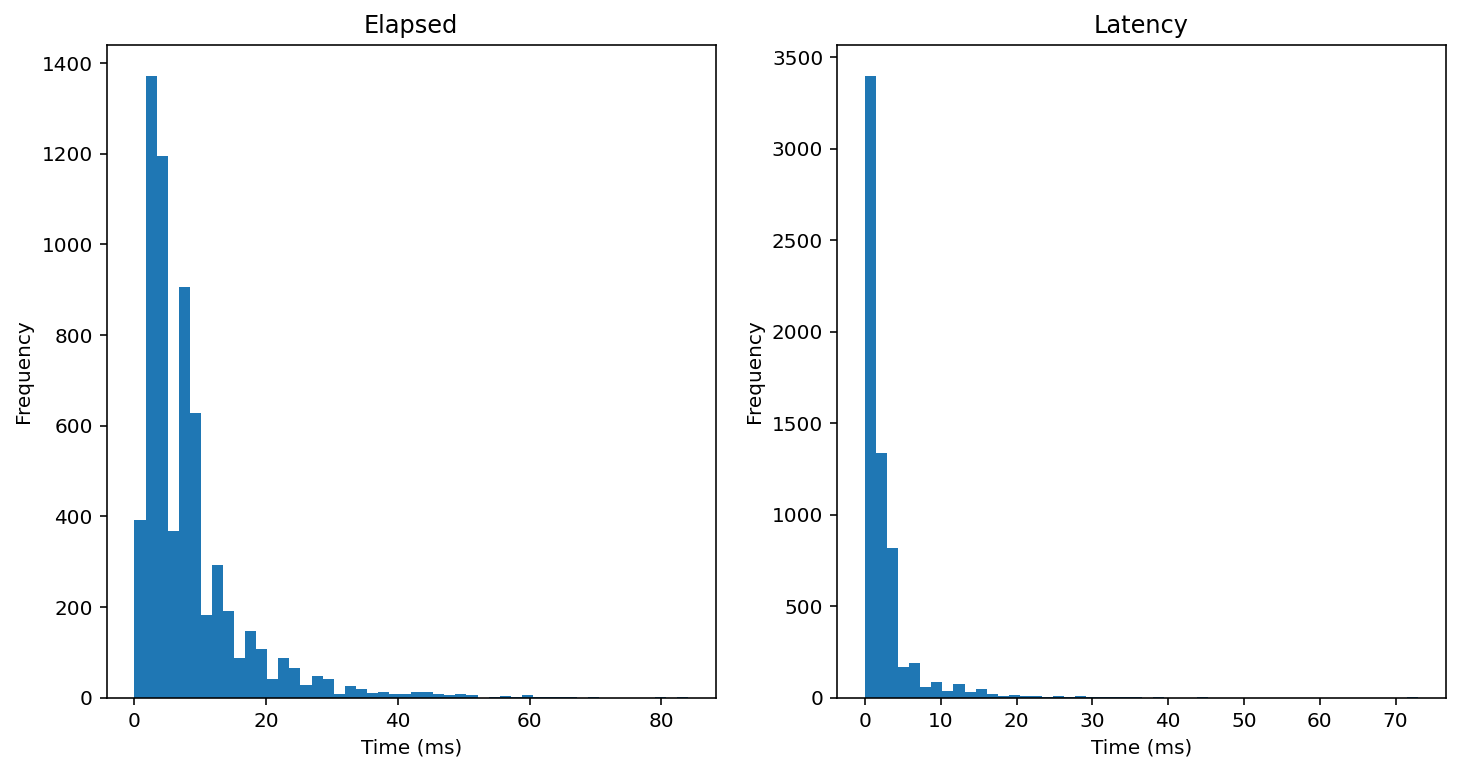

In [15]:
fig = plt.figure(figsize=(12,6))

ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

df_high.elapsed.plot.hist(bins=50, ax=ax0)
df_high.Latency.plot.hist(bins=50, ax=ax1)

ax0.set_title('Elapsed')
ax0.set_xlabel('Time (ms)')
# ax0.set_xticks(np.arange(0, max(df_high.elapsed), 5))

ax1.set_title('Latency')
ax1.set_xlabel('Time (ms)')
# ax1.set_xticks(np.arange(0, max(df_high.Latency), 5))

plt.show()

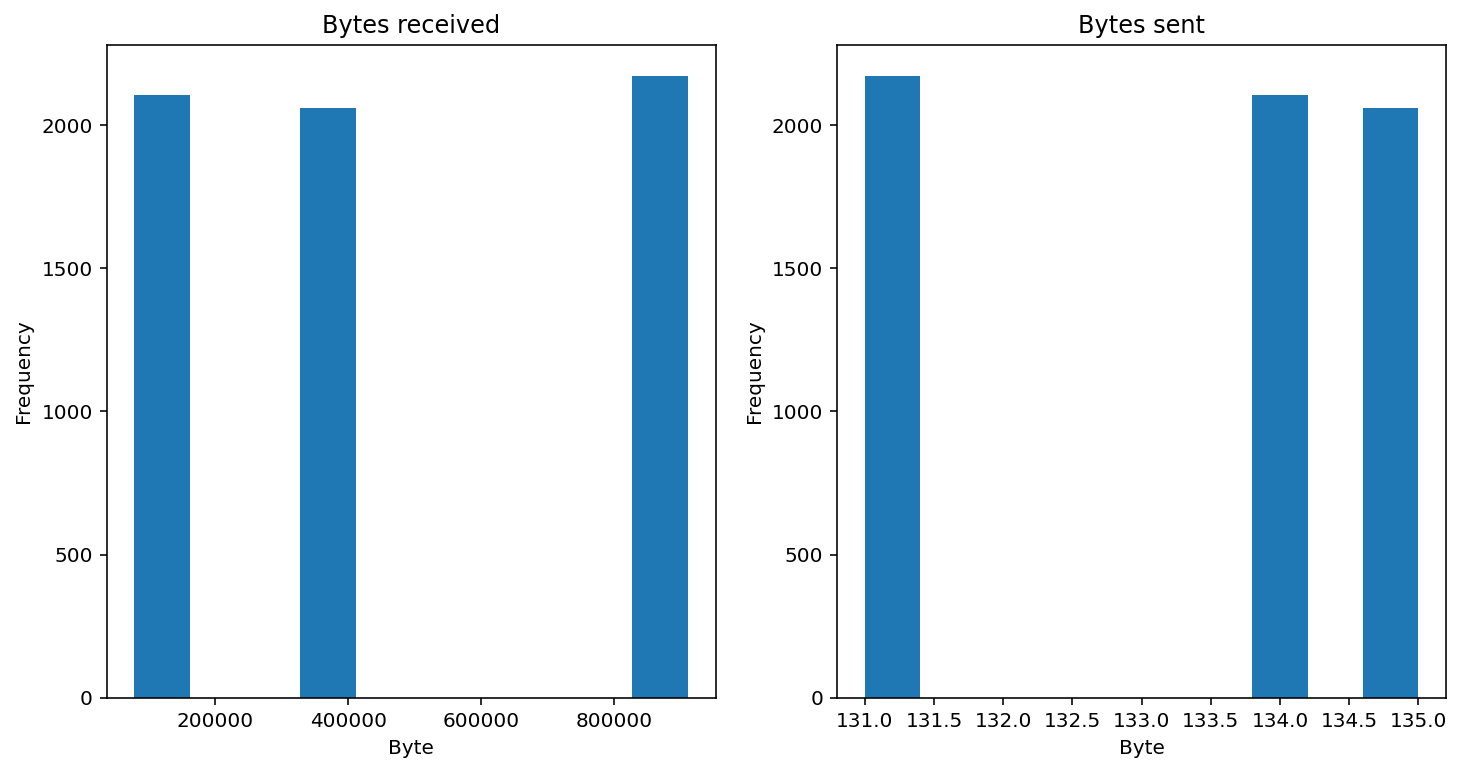

In [16]:
fig = plt.figure(figsize=(12,6))

ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

df_high.bytes.plot.hist(ax=ax0)
df_high.sentBytes.plot.hist(ax=ax1)

ax0.set_title('Bytes received')
ax0.set_xlabel('Byte')

ax1.set_title('Bytes sent')
ax1.set_xlabel('Byte')

plt.show()

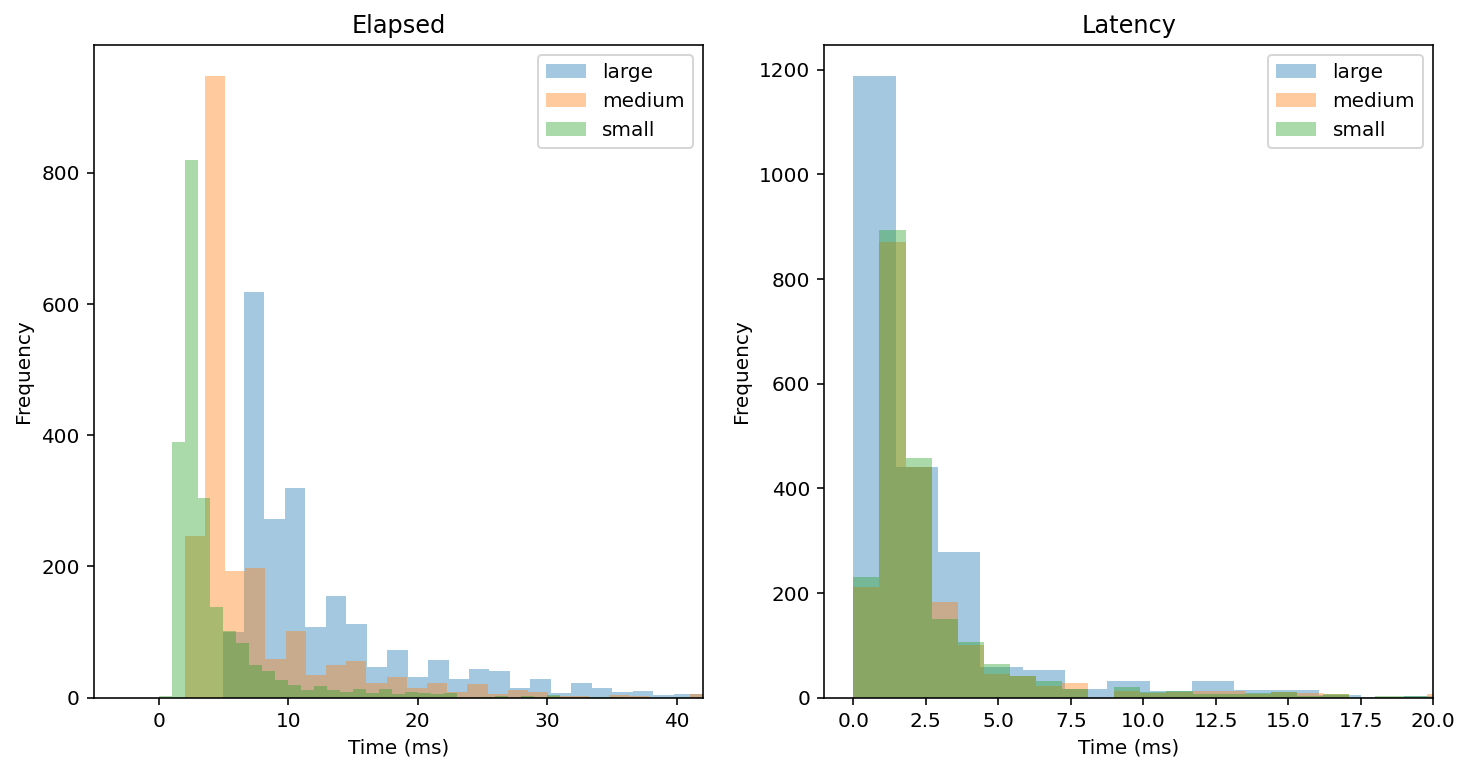

In [17]:
fig = plt.figure(figsize=(12,6))

ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

df_high.groupby(by='resourceType').elapsed.plot.hist(bins=50, alpha=0.4, legend=True, ax=ax0)
df_high.groupby(by='resourceType').Latency.plot.hist(bins=50, alpha=0.4, legend=True, ax=ax1)

x_max = df_high.quantile(q=0.99).elapsed
ax0.set_xlim(-5,x_max)
ax0.set_title('Elapsed')
ax0.set_xlabel('Time (ms)')
# ax0.set_xticks(np.arange(0, max(df_high.elapsed)+1, 5))

x_max = df_high.quantile(q=0.99).Latency
ax1.set_xlim(-1,x_max)
ax1.set_title('Latency')
ax1.set_xlabel('Time (ms)')
# ax1.set_xticks(np.arange(0, max(df_high.Latency)+1, 5))

plt.show()

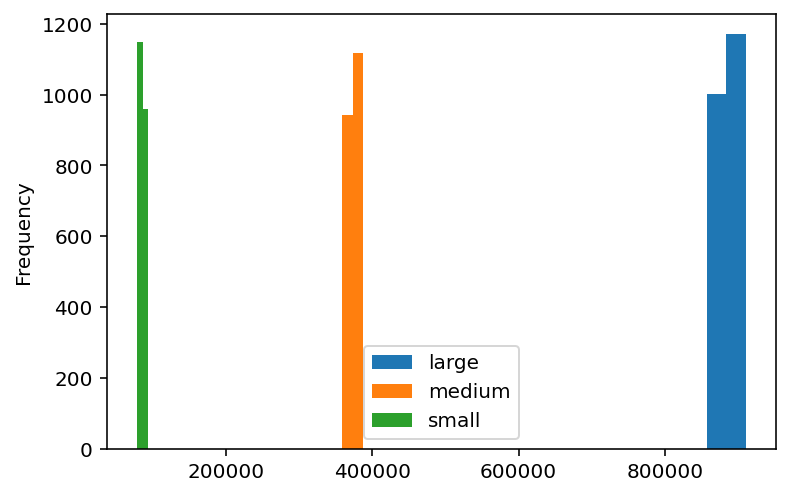

In [18]:
df_high.groupby(by='resourceType').bytes.plot.hist(bins=2, alpha=1, legend=True)

plt.show()

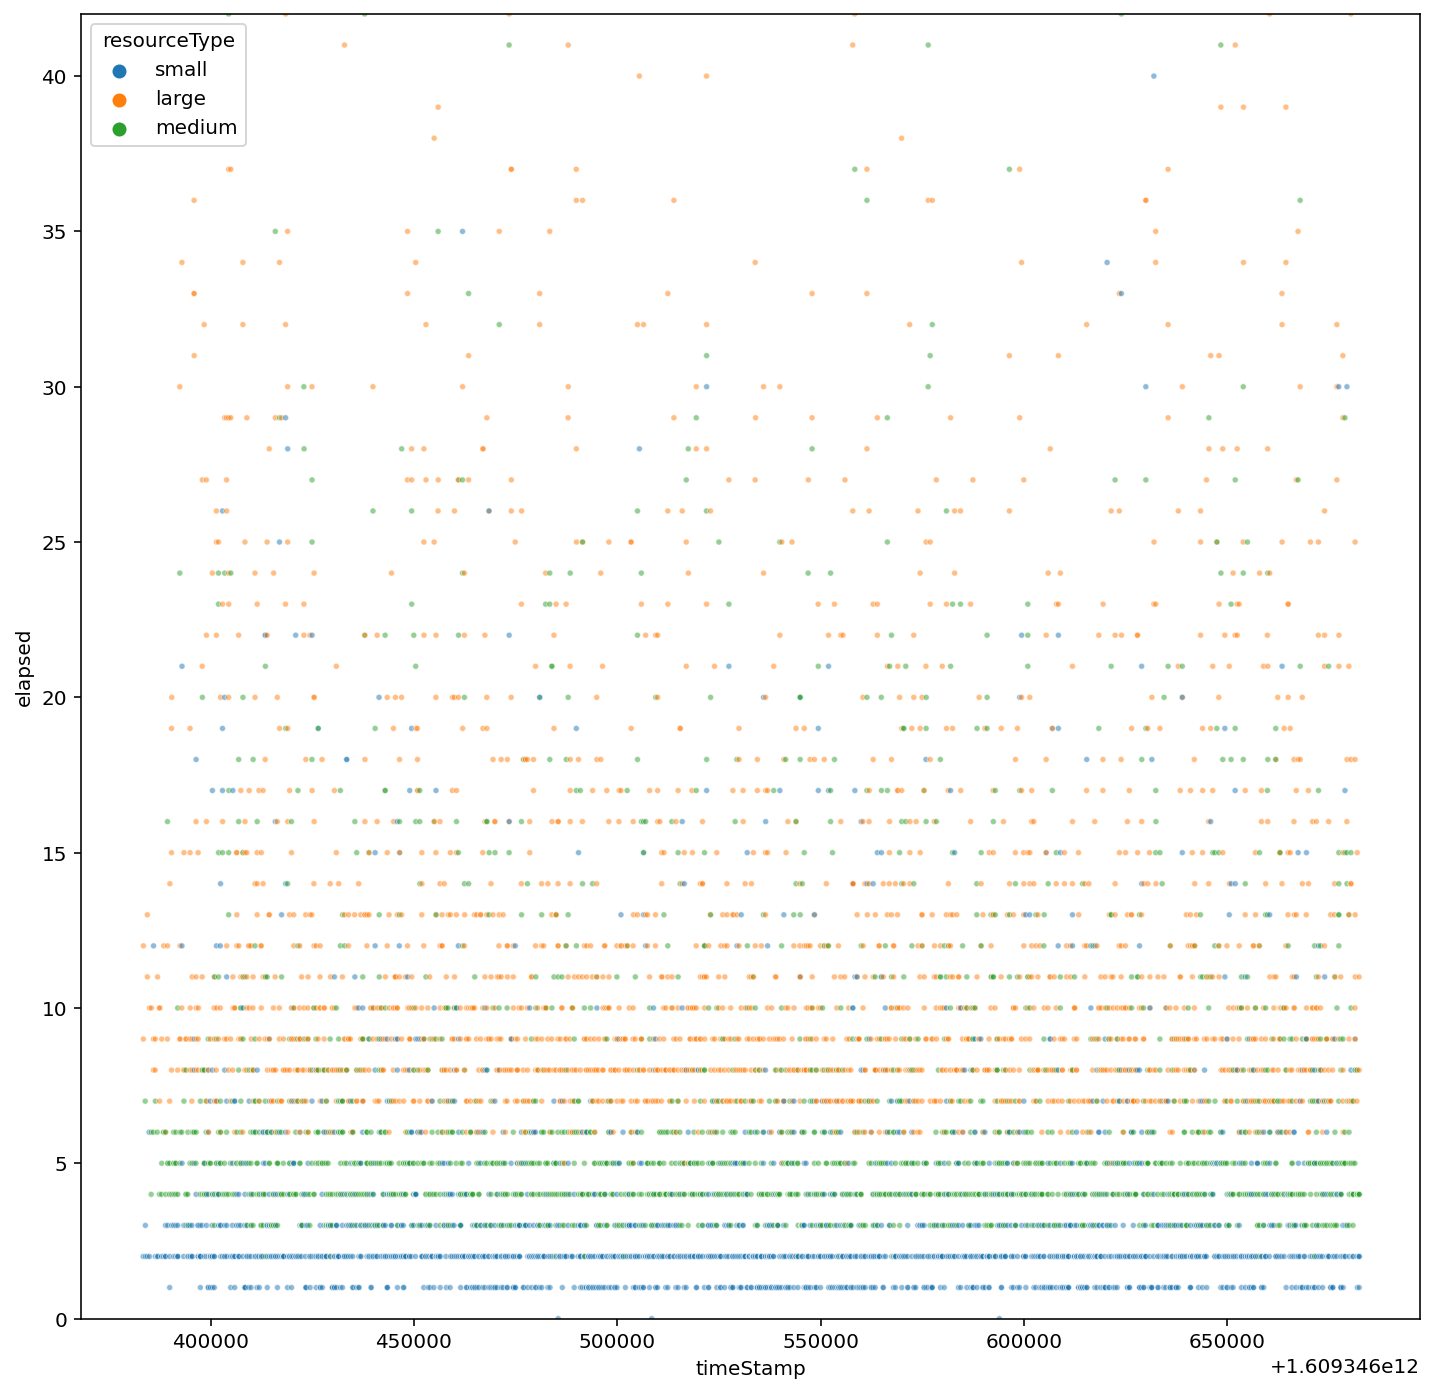

In [19]:
fig, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(x='timeStamp', y='elapsed', hue='resourceType', data=df_high, marker='.', alpha=.5)
y_max = df_high.quantile(q=0.99).elapsed
plt.ylim(0,y_max)
plt.show()

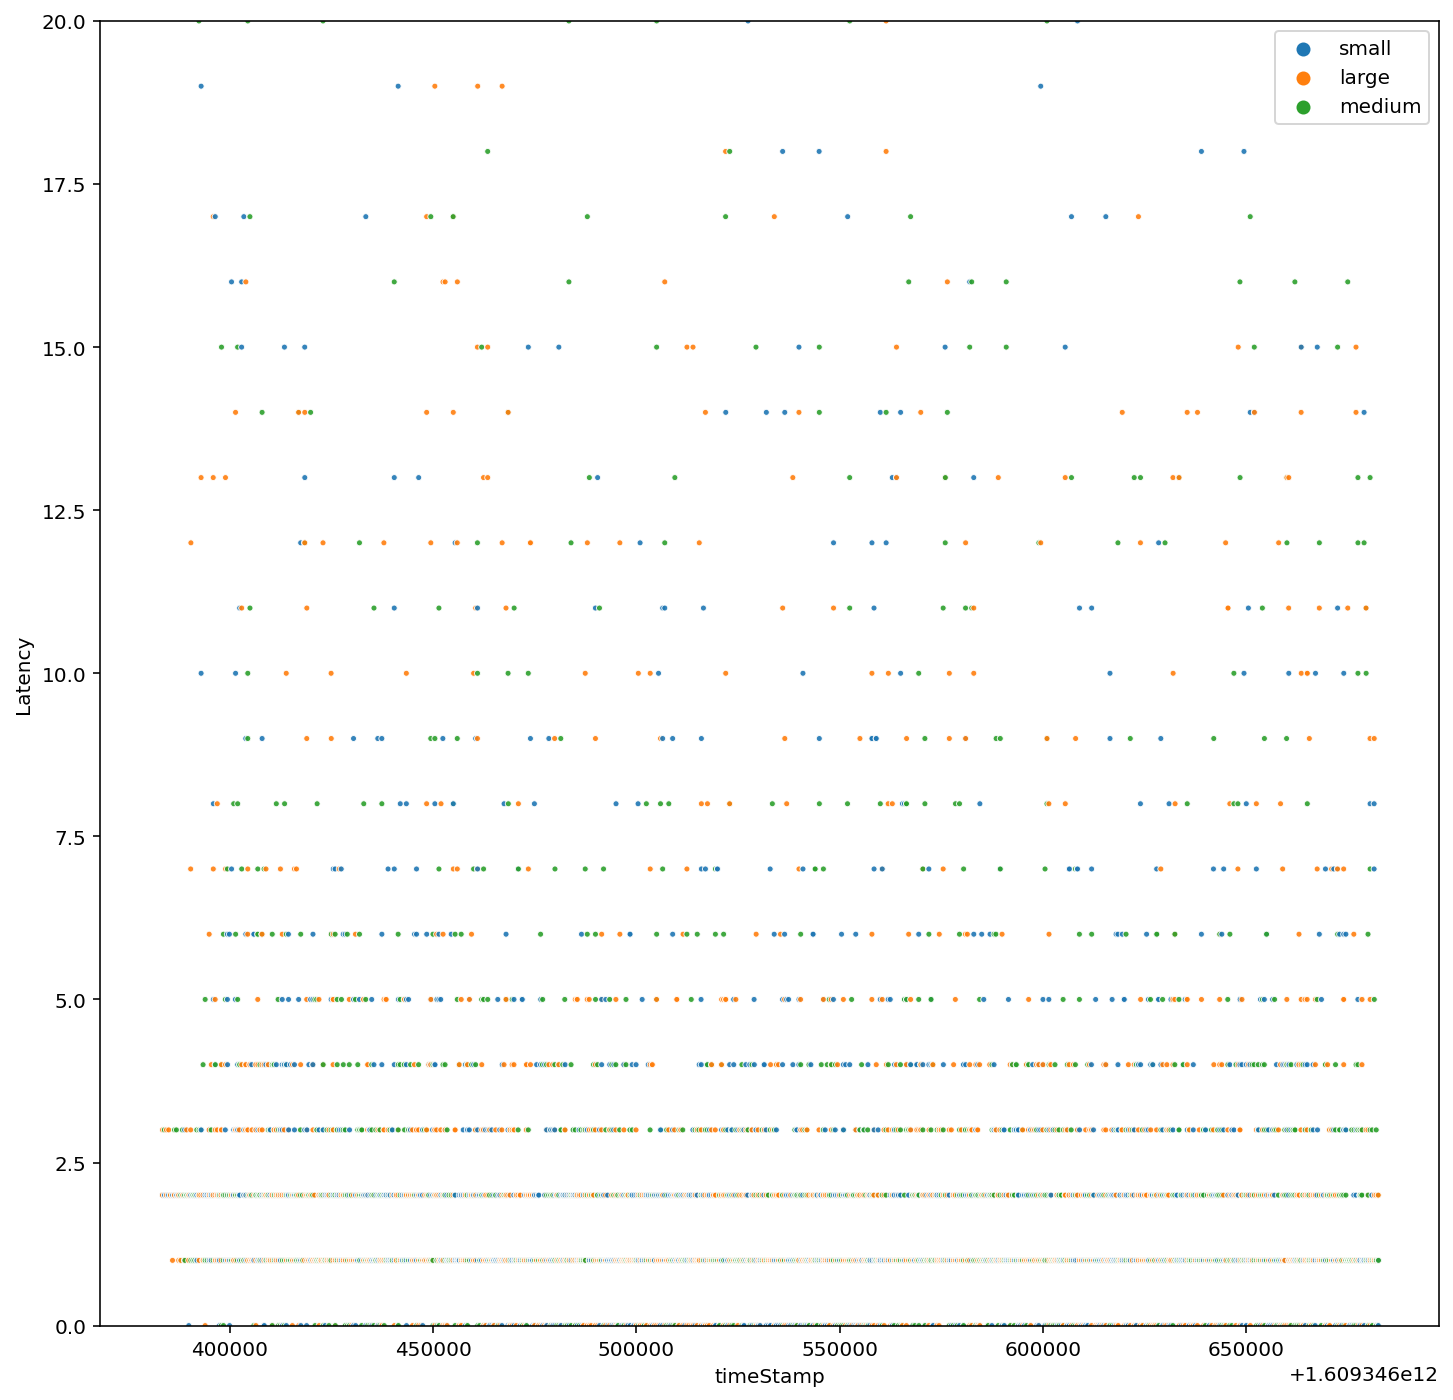

In [20]:
fig, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(x='timeStamp', y='Latency', hue='resourceType', data=df_high, marker='.', alpha=.9)
y_max = df_high.quantile(q=0.99).Latency
plt.legend(loc='upper right')
plt.ylim(0,y_max)
plt.show()

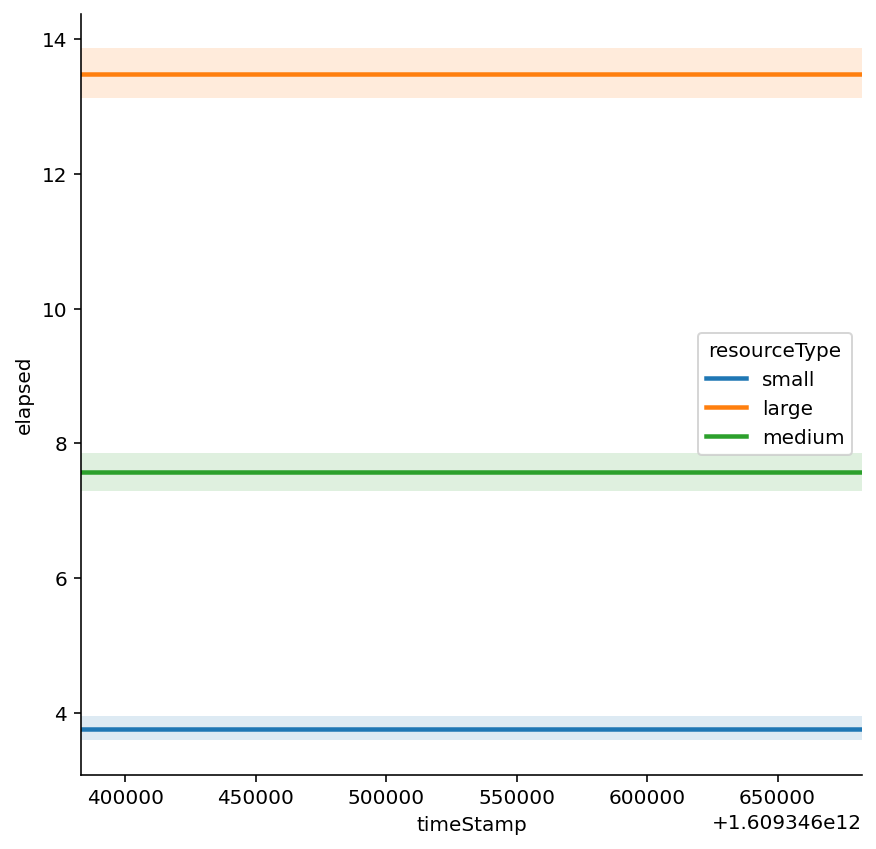

In [21]:
sns.lmplot(x='timeStamp', y='elapsed', hue='resourceType', data=df_high, markers='.', legend_out=False, scatter=False, height=6)
plt.show()

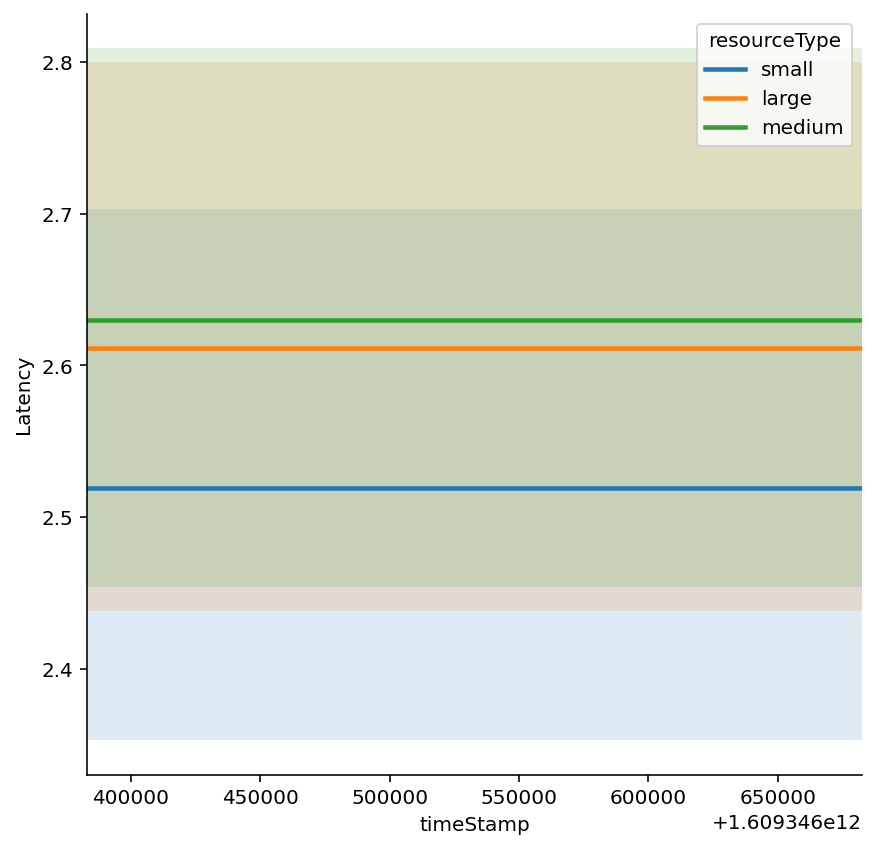

In [22]:
sns.lmplot(x='timeStamp', y='Latency', hue='resourceType', data=df_high, markers='.', legend_out=False, scatter=False, height=6)
plt.show()

## PCA

### Preprocessing

#### Remove nominal columns

In [23]:
df_high_pre = df_high.select_dtypes(include=['int64']).copy().drop(columns='responseCode')
df_high_pre.head()

,timeStamp,elapsed,bytes,sentBytes,grpThreads,allThreads,Latency,IdleTime,Connect
0,1609346383111,48,78492,134,1,3,45,0,30
1,1609346383111,48,911062,131,1,3,45,0,30
2,1609346383111,48,387753,135,1,3,45,0,30
3,1609346383422,2,78492,134,2,6,2,0,1
4,1609346383469,9,911062,131,2,6,2,0,1


In [24]:
thread_type_encoder = preprocessing.LabelEncoder()
thread_type_encoder.fit(['slow','fast','home'])

df_high_pre['threadType'] = thread_type_encoder.transform(df_high['threadType'])
df_high_pre

,timeStamp,elapsed,bytes,sentBytes,grpThreads,allThreads,Latency,IdleTime,Connect,threadType
0,1609346383111,48,78492,134,1,3,45,0,30,2
1,1609346383111,48,911062,131,1,3,45,0,30,0
2,1609346383111,48,387753,135,1,3,45,0,30,1
3,1609346383422,2,78492,134,2,6,2,0,1,0
4,1609346383469,9,911062,131,2,6,2,0,1,2
...,...,...,...,...,...,...,...,...,...,...
6333,1609346682424,11,911061,131,4,5,1,0,0,0
6334,1609346682433,8,911061,131,3,4,2,0,0,0
6335,1609346682442,1,78491,134,2,3,0,0,0,0
6336,1609346682458,2,93220,134,1,2,1,0,0,2


#### Remove constant components

In [25]:
df_const = df_high_pre.loc[:,df_high_pre.columns[df_high_pre.nunique() == 1]]
df_const.head()

,IdleTime
0,0
1,0
2,0
3,0
4,0


In [26]:
df_high_pre = df_high_pre.loc[:,df_high_pre.columns[df_high_pre.nunique() != 1]]
df_high_pre.head()

,timeStamp,elapsed,bytes,sentBytes,grpThreads,allThreads,Latency,Connect,threadType
0,1609346383111,48,78492,134,1,3,45,30,2
1,1609346383111,48,911062,131,1,3,45,30,0
2,1609346383111,48,387753,135,1,3,45,30,1
3,1609346383422,2,78492,134,2,6,2,1,0
4,1609346383469,9,911062,131,2,6,2,1,2


#### Remove perfectly correlated components

In [27]:
df_corr = df_high_pre.corr()
df_corr

,timeStamp,elapsed,bytes,sentBytes,grpThreads,allThreads,Latency,Connect,threadType
timeStamp,1.000000,-0.011575,0.002689,0.010882,0.085292,0.057491,-0.036725,-0.050421,-0.006055
elapsed,-0.011575,1.000000,0.495622,-0.398989,-0.019038,-0.009292,0.628795,0.291343,0.036047
bytes,0.002689,0.495622,1.000000,-0.824786,0.006180,-0.007324,0.008536,0.005382,-0.016702
sentBytes,0.010882,-0.398989,-0.824786,1.000000,-0.012107,-0.004037,-0.001676,-0.000335,0.010106
grpThreads,0.085292,-0.019038,0.006180,-0.012107,1.000000,0.603641,-0.055446,-0.194612,-0.097309
allThreads,0.057491,-0.009292,-0.007324,-0.004037,0.603641,1.000000,-0.046135,-0.099155,-0.010379
Latency,-0.036725,0.628795,0.008536,-0.001676,-0.055446,-0.046135,1.000000,0.432882,0.051224
Connect,-0.050421,0.291343,0.005382,-0.000335,-0.194612,-0.099155,0.432882,1.000000,0.354500
threadType,-0.006055,0.036047,-0.016702,0.010106,-0.097309,-0.010379,0.051224,0.354500,1.000000


#### Normalize the components

In [56]:
x = df_high_pre.values

x_scaled = StandardScaler().fit_transform(x)

df_high_pre = pd.DataFrame(data=x_scaled, columns=df_high_pre.columns )
df_high_pre.head()

,timeStamp,elapsed,bytes,sentBytes,grpThreads,allThreads,Latency,Connect,threadType
0,-1.810683,4.874108,-1.122889,0.411446,-5.338260,-8.411108,10.689706,20.672621,1.434312
1,-1.810683,4.874108,1.369048,-1.345795,-5.338260,-8.411108,10.689706,20.672621,-0.763625
2,-1.810683,4.874108,-0.197250,0.997193,-5.338260,-8.411108,10.689706,20.672621,0.335343
3,-1.807004,-0.777799,-1.122889,0.411446,-5.192324,-8.144168,-0.147930,0.348862,-0.763625
4,-1.806449,0.082274,1.369048,-1.345795,-5.192324,-8.144168,-0.147930,0.348862,1.434312


### Perform PCA

In [77]:
# Attenzione!!!
df_high_pre.drop(columns=['Latency','Connect'], inplace=True)

In [79]:
pca = PCA()

princ_comp = pca.fit(df_high_pre.values)

In [80]:
d = pca.transform(df_high_pre.values)

c = [str(s) for s in range(princ_comp.n_components_)]
c = ['comp ' + s for s in c]

df_high_pca = pd.DataFrame(data=d, columns=c)
df_high_pca.head()

,comp 0,comp 1,comp 2,comp 3,comp 4,comp 5,comp 6
0,1.460030,10.083817,0.432482,-0.301328,4.328290,2.367768,1.154710
1,4.106968,9.753800,-1.823282,0.211094,3.229217,2.113246,0.530542
2,1.687859,9.949808,-0.630539,-0.064187,4.473448,2.270422,0.095948
3,-1.239911,9.413066,-2.180919,0.231527,-0.303212,1.962865,0.522721
4,1.820522,9.639054,-0.133494,-0.151645,-1.165941,2.161479,-0.050387


#### Explained variance

In [81]:
d = {'explained variance': princ_comp.explained_variance_, 'explained variance ratio': princ_comp.explained_variance_ratio_}

df_variance_PCA = pd.DataFrame(data=d)

df_variance_PCA['cumulative explained variance ratio'] = df_variance_PCA.cumsum()['explained variance ratio']
df_variance_PCA.head(10)

,explained variance,explained variance ratio,cumulative explained variance ratio
0,2.168549,0.309744,0.309744
1,1.630389,0.232876,0.542620
2,1.002197,0.143148,0.685768
3,0.983709,0.140508,0.826276
4,0.659868,0.094252,0.920528
5,0.389379,0.055617,0.976145
6,0.167014,0.023855,1.000000


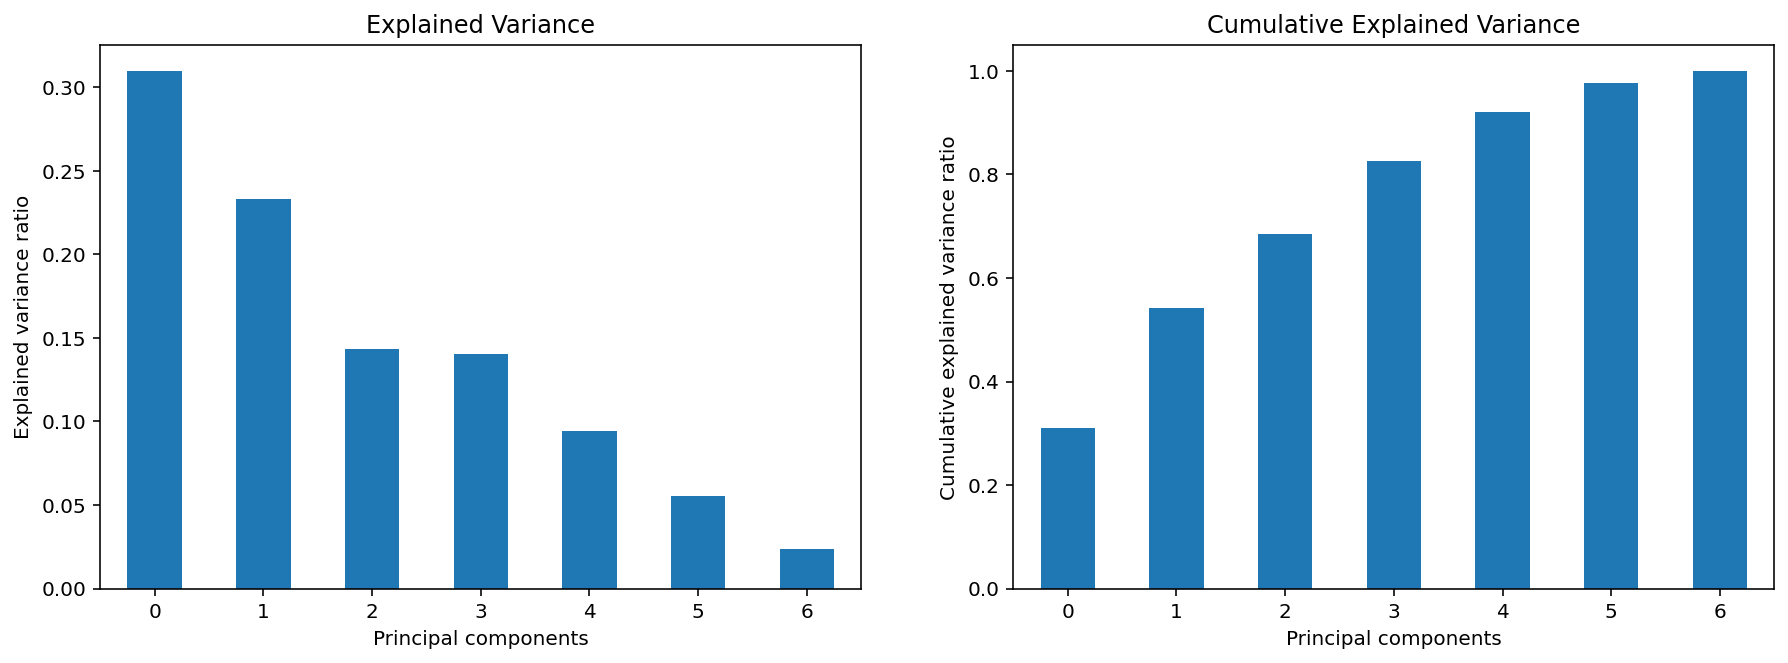

In [82]:
fig = plt.figure(figsize=(15,5))


ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

df_variance_PCA.plot.bar(y=['explained variance ratio'], ax=ax0, legend=False)
df_variance_PCA.plot.bar(y=['cumulative explained variance ratio'], ax=ax1, legend=False)

ax0.tick_params(labelrotation=0)
ax0.set_title('Explained Variance')
ax0.set_xlabel('Principal components')
ax0.set_ylabel('Explained variance ratio')

ax1.tick_params(labelrotation=0)
ax1.set_title('Cumulative Explained Variance')
ax1.set_xlabel('Principal components')
ax1.set_ylabel('Cumulative explained variance ratio')
plt.show()

## Clustering

### Select principal components

In [ ]:
dev_tot = df_high_pre.sub(df_high_pre.mean()).pow(2).sum().sum()

nmin_comp = 4
nmax_comp = 6
n_comp = nmax_comp-nmin_comp+1

nmax_cluster = 50

array_dev_lost = np.zeros(shape=(nmax_cluster,n_comp))
filepath = './array_dev_lost.txt'
if(not os.path.isfile(filepath)):
    print('Creating file',filepath, 'this may take a while...\n')
    
    array_dev_lost = np.zeros(shape=(nmax_cluster,n_comp))
    
    for i in tqdmn(range(nmin_comp, nmax_comp+1), desc='outer loop'):

        for j in tqdmn(range(1, nmax_cluster+1), desc='inner loop'):
            df_clustering = df_high_pca.iloc[:,0:i]

            # clustering
            clustering = AgglomerativeClustering(n_clusters=j)
            clustering = clustering.fit(df_clustering.values)

            df_clustering.insert(len(df_clustering.columns), 'cluster', clustering.labels_)

            # deviance PCA
            df_pca = df_high_pca.iloc[:,0:i]
            dev_pca = df_pca.sub(df_pca.mean()).pow(2).sum().sum()

            # deviance clustering 
            n_elem = df_clustering.groupby('cluster').count().values[:,0]
            centroids = df_clustering.groupby('cluster').mean()

            # intra-cluster deviance
            arr = np.zeros(shape=(j,1))
            for k in range(j):
                elem_k = df_clustering.loc[df_clustering['cluster'] == k].drop(columns='cluster')
                arr[k] = elem_k.sub(centroids.loc[k,:]).pow(2).sum().sum()
            dev_intra = arr.sum()

            # inter-cluster deviance
            dev_inter = centroids.sub(df_clustering.mean()).pow(2).mul(n_elem, axis=0).sum().sum()
            dev_inter

            # deviance lost
            dev_pca_ratio = dev_pca/dev_tot
            dev_inter_ratio = dev_inter/dev_pca
            dev_lost = 1 - dev_inter_ratio * dev_pca_ratio

            array_dev_lost[j-1][i-n_comp-1] = dev_lost
            
#             print(array_dev_lost)
    with open (filepath, 'wb') as fp:
        pickle.dump(array_dev_lost, fp)

else:
    print('File already exists!\n')
    with open (filepath, 'rb') as fp:
        array_dev_lost = pickle.load(fp)
        
        
# array_dev_lost

Creating file ./array_dev_lost.txt this may take a while...



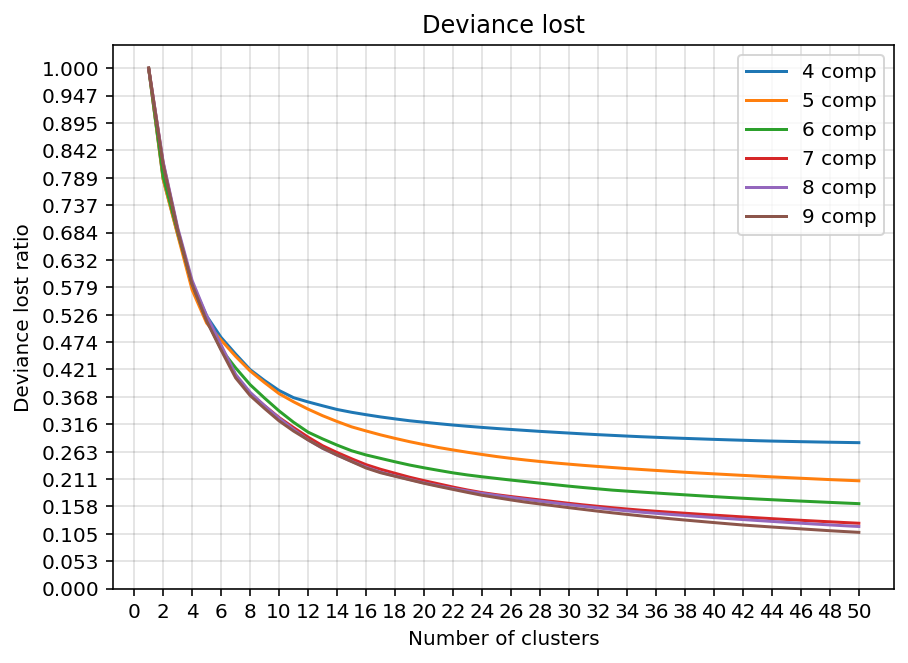

In [62]:
x = np.arange(1,nmax_cluster+1)

plt.figure(figsize=(7,5))

for i in range(nmin_comp,nmax_comp+1):
    y_dev_lost = array_dev_lost[:,i-n_comp]
    plt.plot(x, y_dev_lost)
    
c = [str(s) for s in range(nmin_comp,nmax_comp+1)]
c = [s + ' comp' for s in c]
    
plt.title('Deviance lost')
plt.ylabel('Deviance lost ratio')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(0,nmax_cluster+1,2))
plt.yticks(np.linspace(0,y_dev_lost.max(),20))
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.legend(c)
plt.show()

In [63]:
n_comp = 6
df_high_cl = df_high_pca.iloc[:,0:n_comp]
df_high_cl.head()

,comp 0,comp 1,comp 2,comp 3,comp 4,comp 5
0,13.415712,18.890147,4.146692,1.172873,0.343035,9.794115
1,15.200704,16.739363,2.687261,2.250220,0.409215,11.274867
2,13.481792,18.474017,3.886944,2.017720,0.443000,10.320455
3,0.171065,6.412197,-7.083113,1.973358,-0.073933,-0.339520
4,2.887850,5.439673,-7.656743,-0.231086,-0.310282,-1.309808


### Perform clustering

In [68]:
n_clusters = 6

clustering = AgglomerativeClustering(n_clusters=n_clusters)
clustering = clustering.fit(df_high_cl.values)

In [69]:
df_high_clu = df_high
df_high_clu.loc[:,'cluster'] = clustering.labels_
df_high_clu.head()

,timeStamp,elapsed,label,responseCode,responseMessage,threadName,dataType,success,failureMessage,bytes,sentBytes,grpThreads,allThreads,URL,Latency,IdleTime,Connect,resourceType,threadType,cluster
0,1609346383111,48,HTTP Request - Wikipedia Home,200,OK,Thread Group - Slow 1-1,text,True,NaN,78492,134,1,3,http://192.168.56.101/WikipediaHome.html,45,0,30,small,slow,3
1,1609346383111,48,HTTP Request - Reddit Home,200,OK,Thread Group - Fast 2-1,text,True,NaN,911062,131,1,3,http://192.168.56.101/RedditHome.html,45,0,30,large,fast,3
2,1609346383111,48,HTTP Request - Repubblica Home,200,OK,Thread Group - Home 3-1,text,True,NaN,387753,135,1,3,http://192.168.56.101/RepubblicaHome.html,45,0,30,medium,home,3
3,1609346383422,2,HTTP Request - Wikipedia Home,200,OK,Thread Group - Fast 2-2,text,True,NaN,78492,134,2,6,http://192.168.56.101/WikipediaHome.html,2,0,1,small,fast,5
4,1609346383469,9,HTTP Request - Reddit Home,200,OK,Thread Group - Slow 1-2,text,True,NaN,911062,131,2,6,http://192.168.56.101/RedditHome.html,2,0,1,large,slow,5


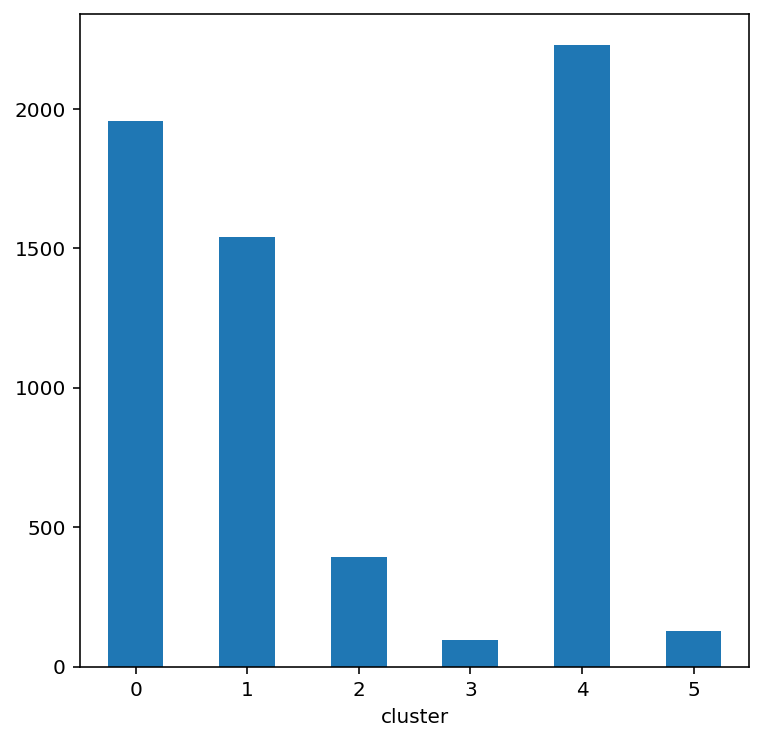

In [70]:
df_high_clu.groupby(by='cluster').count().timeStamp.plot.bar(figsize=(6,6))
plt.xticks(rotation=0)
plt.show()

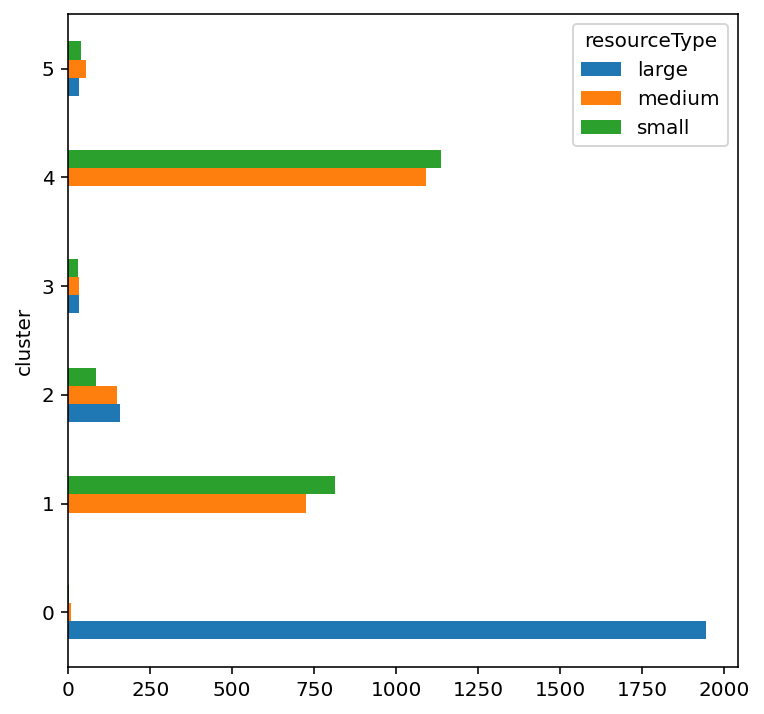

In [71]:
df_high_clu.groupby(by=['cluster','resourceType']).count().timeStamp.unstack(1).plot.barh(figsize=(6,6))
plt.show()

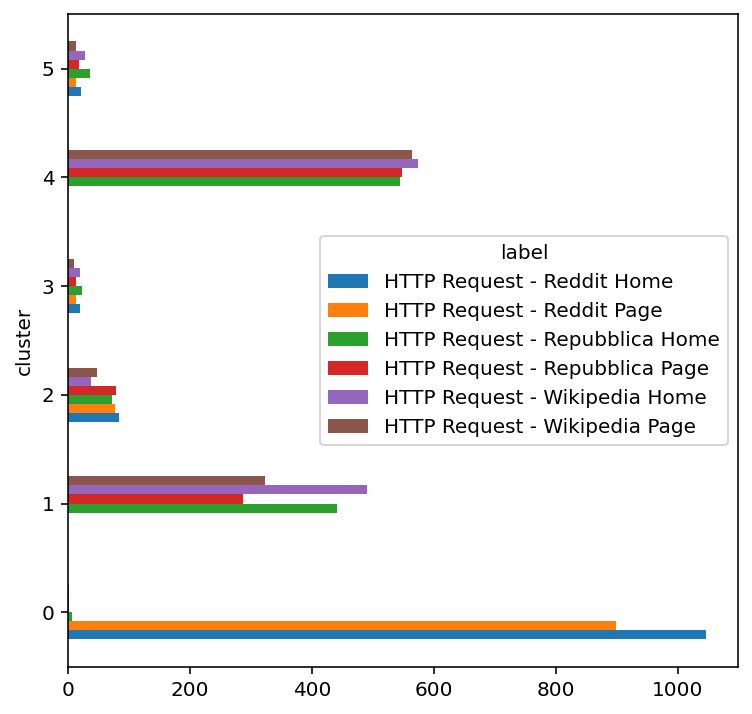

In [73]:
df_high_clu.groupby(by=['cluster','label']).count().timeStamp.unstack(1).plot.barh(figsize=(6,6))
plt.show()

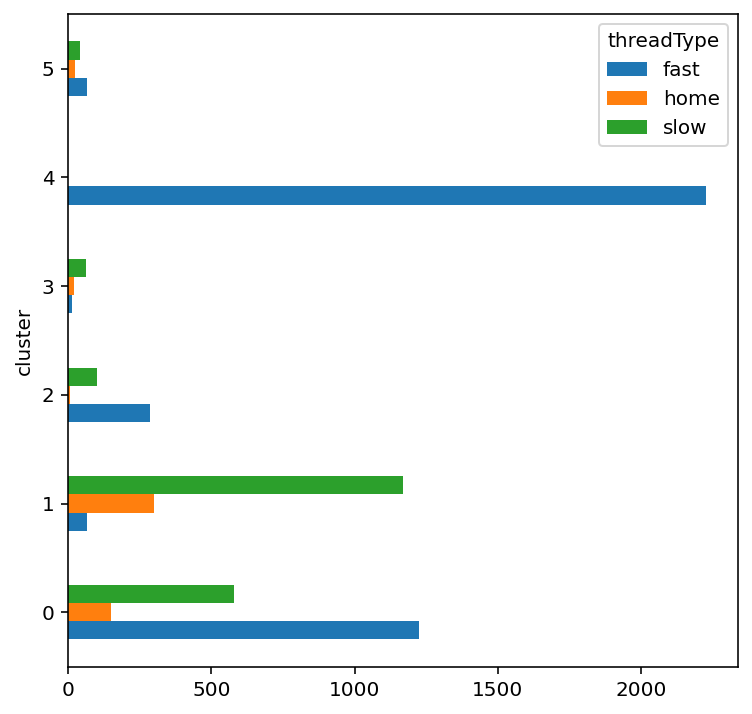

In [72]:
df_high_clu.groupby(by=['cluster','threadType']).count().timeStamp.unstack(1).plot.barh(figsize=(6,6))
plt.show()

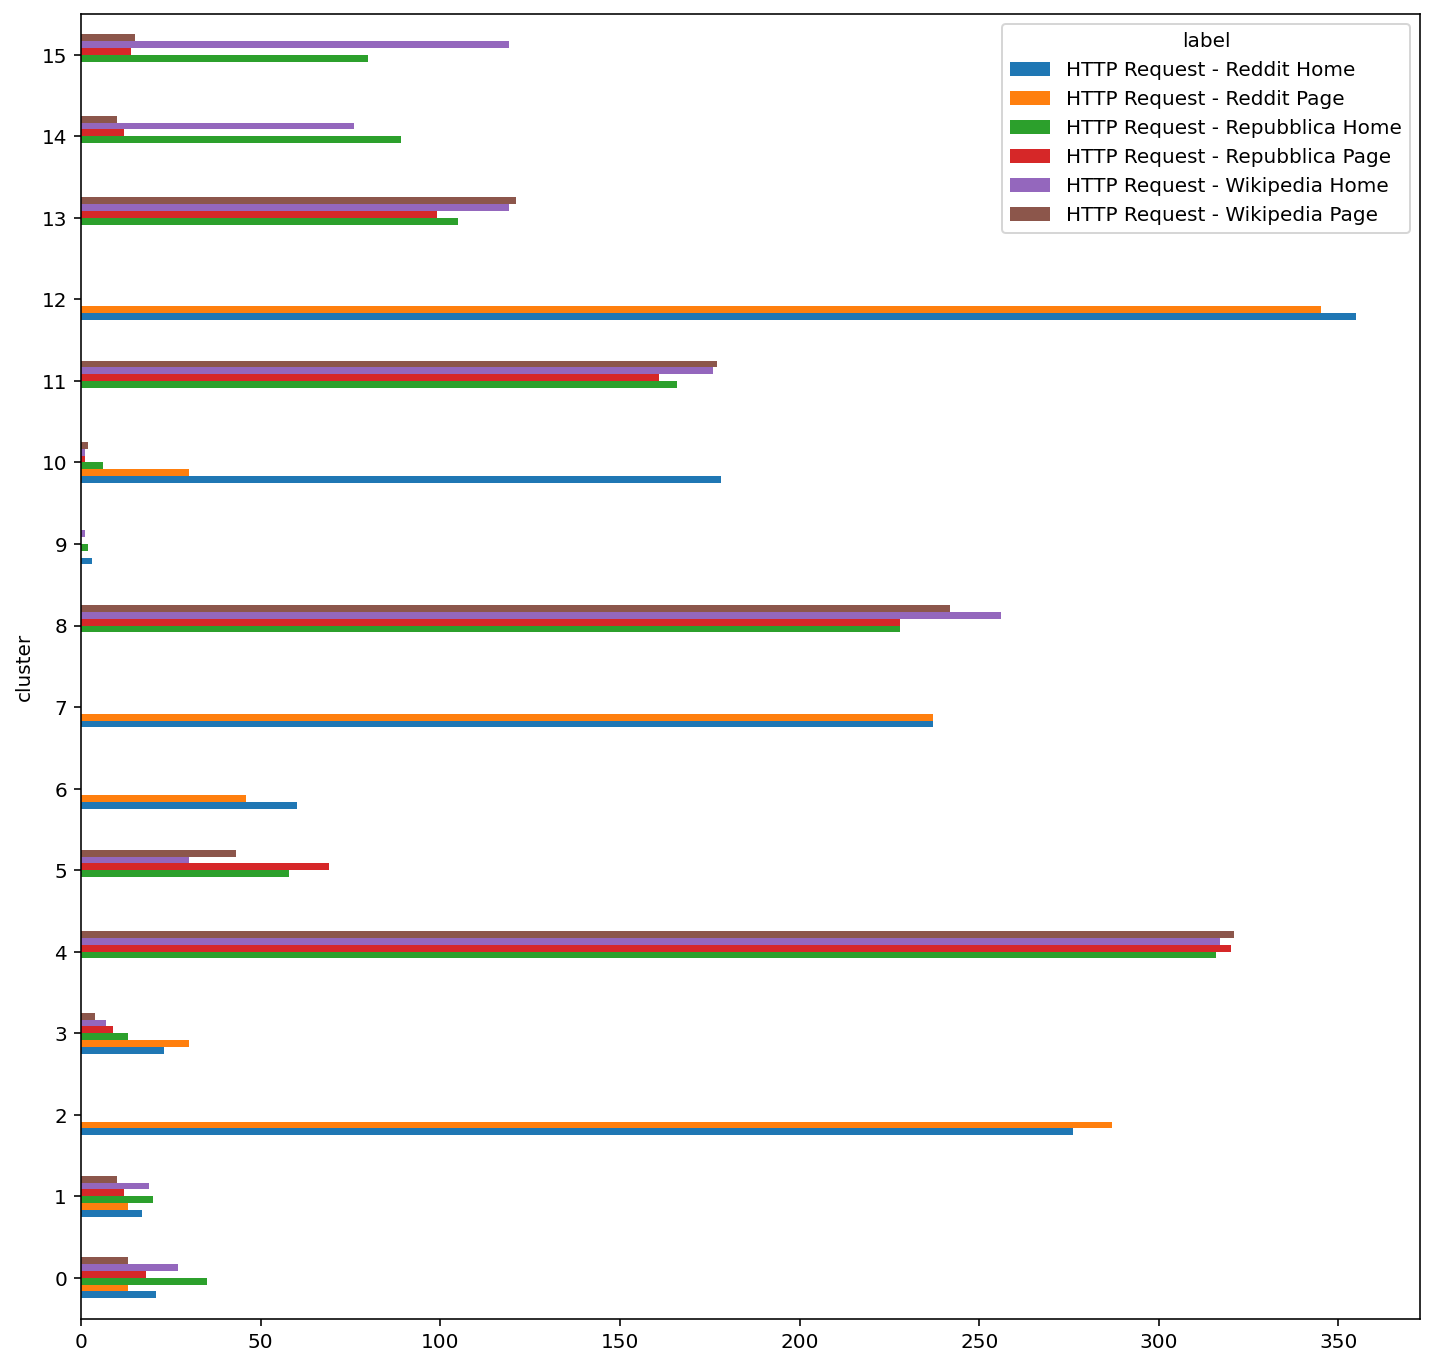

In [41]:
df_high_clu.groupby(by=['cluster','label']).count().timeStamp.unstack(1).plot.barh(figsize=(12,12))
plt.show()

## Synthetic workload

In [42]:
# Correggere questa sezione

In [43]:
# df_high_clu.groupby(by=['cluster','threadType','label']).count().max(level=[0,1,2])

In [44]:
# df_synth = df_high_clu.groupby('cluster').apply(lambda x: x.sample())
# df_synth = df_synth.reset_index(level=0, col_level=2 , drop=True)
# df_synth

# Low level parameters

## Read data

In [45]:
df_low = pd.read_csv('WC_report_server.csv', sep='\s+', skiprows=1)
df_low.rename(columns={'r':'procs_r', 'b':'procs_b',
                       'swpd':'memory_swpd', 'free':'memory_free', 'buff':'memory_buff', 'cache':'memory_cache', 
                       'si':'swap_si', 'so':'swap_so', 
                       'bi':'io_bi', 'bo':'io_bo',
                       'in':'system_in', 'cs':'system_cs',
                       'us':'cpu_us', 'sy':'cpu_sy', 'id':'cpu_id', 'wa':'cpu_wa', 'st':'cpu_st'
                      }, inplace=True)
df_low.head()

,procs_r,procs_b,memory_swpd,memory_free,memory_buff,memory_cache,swap_si,swap_so,io_bi,io_bo,system_in,system_cs,cpu_us,cpu_sy,cpu_id,cpu_wa,cpu_st
0,3,0,0,753576,47736,611564,0,0,689,41,470,435,5,4,87,4,0
1,0,0,0,753568,47740,611504,0,0,4,36,402,1212,11,1,87,1,0
2,0,0,0,753568,47740,611504,0,0,0,0,82,180,3,0,97,0,0
3,0,0,0,753568,47740,611504,0,0,0,0,54,90,1,0,99,0,0
4,0,0,0,753568,47740,611504,0,0,0,0,69,157,0,0,100,0,0


In [46]:
print('The dataset contains', df_low.shape[1], 'columns and', df_low.shape[0], 'rows')

The dataset contains 17 columns and 310 rows


## Data analysis

In [47]:
df_low.describe()

,procs_r,procs_b,memory_swpd,memory_free,memory_buff,memory_cache,swap_si,swap_so,io_bi,io_bo,system_in,system_cs,cpu_us,cpu_sy,cpu_id,cpu_wa,cpu_st
count,310.000000,310.0,310.0,310.000000,310.000000,310.000000,310.0,310.0,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.0
mean,0.345161,0.0,0.0,747984.180645,48428.503226,612237.574194,0.0,0.0,3.990323,11.280645,1060.254839,378.667742,0.974194,7.312903,91.106452,0.590323,0.0
std,0.767604,0.0,0.0,3136.625420,353.353978,397.229238,0.0,0.0,49.780651,45.052741,246.720909,140.957989,1.235654,2.297211,3.023900,1.542254,0.0
min,0.000000,0.0,0.0,729492.000000,47736.000000,611500.000000,0.0,0.0,0.000000,0.000000,54.000000,90.000000,0.000000,0.000000,73.000000,0.000000,0.0
25%,0.000000,0.0,0.0,747364.000000,48430.000000,612109.000000,0.0,0.0,0.000000,0.000000,960.250000,332.000000,0.000000,6.000000,90.000000,0.000000,0.0
50%,0.000000,0.0,0.0,747364.000000,48556.000000,612318.000000,0.0,0.0,0.000000,0.000000,1101.000000,360.000000,1.000000,8.000000,91.000000,0.000000,0.0
75%,0.000000,0.0,0.0,747616.000000,48676.000000,612552.000000,0.0,0.0,0.000000,16.000000,1222.000000,397.000000,1.000000,9.000000,93.000000,0.000000,0.0
max,5.000000,0.0,0.0,753576.000000,48796.000000,612780.000000,0.0,0.0,689.000000,712.000000,1574.000000,1921.000000,11.000000,14.000000,100.000000,13.000000,0.0


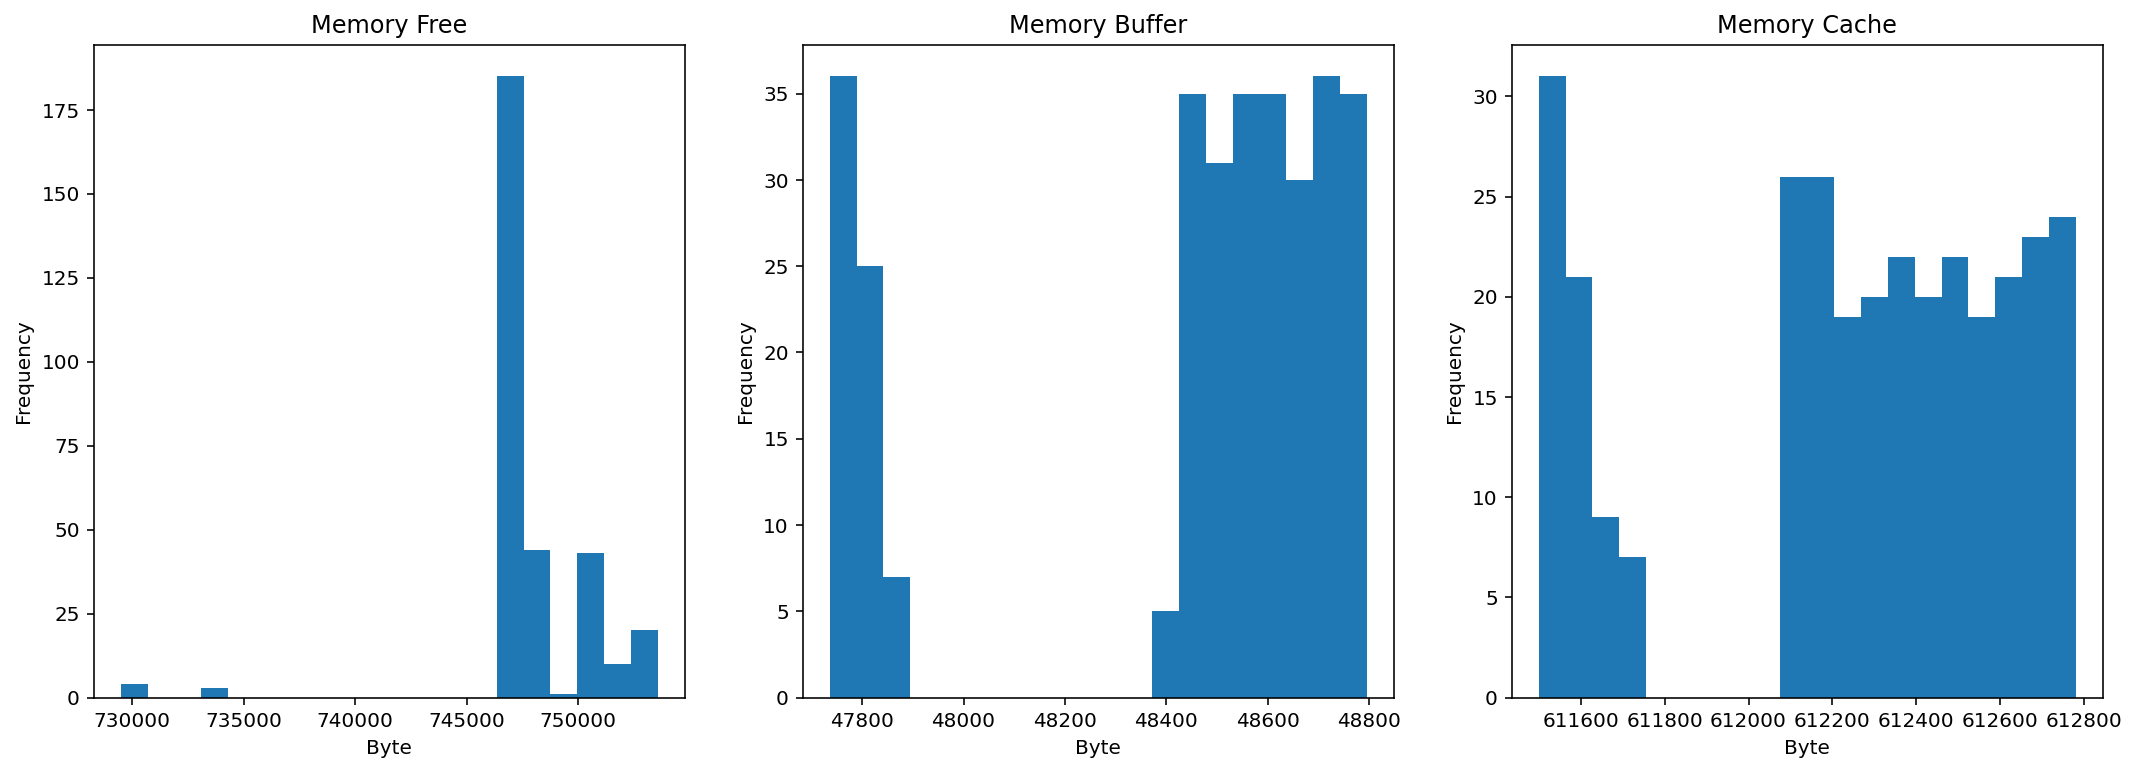

In [48]:
fig = plt.figure(figsize=(18,6))

ax0 = fig.add_subplot(1,3,1)
ax1 = fig.add_subplot(1,3,2)
ax2 = fig.add_subplot(1,3,3)

df_low.memory_free.plot.hist(bins=20, ax=ax0)
df_low.memory_buff.plot.hist(bins=20, ax=ax1)
df_low.memory_cache.plot.hist(bins=20, ax=ax2)

ax0.set_title('Memory Free')
ax0.set_xlabel('Byte')
# ax0.set_xticks(np.arange(0, max(df_high.elapsed), 5))

ax1.set_title('Memory Buffer')
ax1.set_xlabel('Byte')
# ax1.set_xticks(np.arange(0, max(df_high.Latency), 5))

ax2.set_title('Memory Cache')
ax2.set_xlabel('Byte')

plt.show()

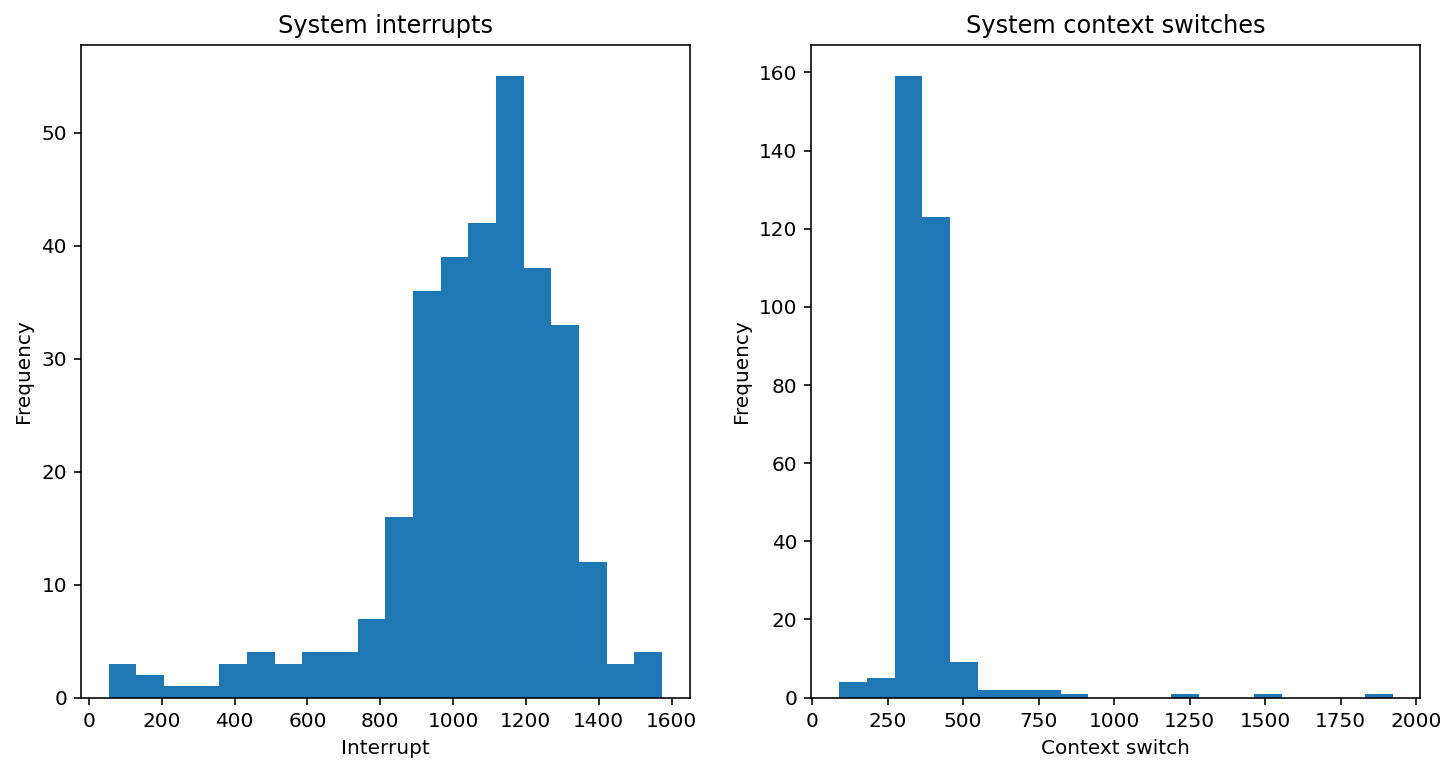

In [49]:
fig = plt.figure(figsize=(12,6))

ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

df_low.system_in.plot.hist(bins=20, ax=ax0)
df_low.system_cs.plot.hist(bins=20, ax=ax1)

ax0.set_title('System interrupts')
ax0.set_xlabel('Interrupt')

ax1.set_title('System context switches')
ax1.set_xlabel('Context switch')

plt.show()

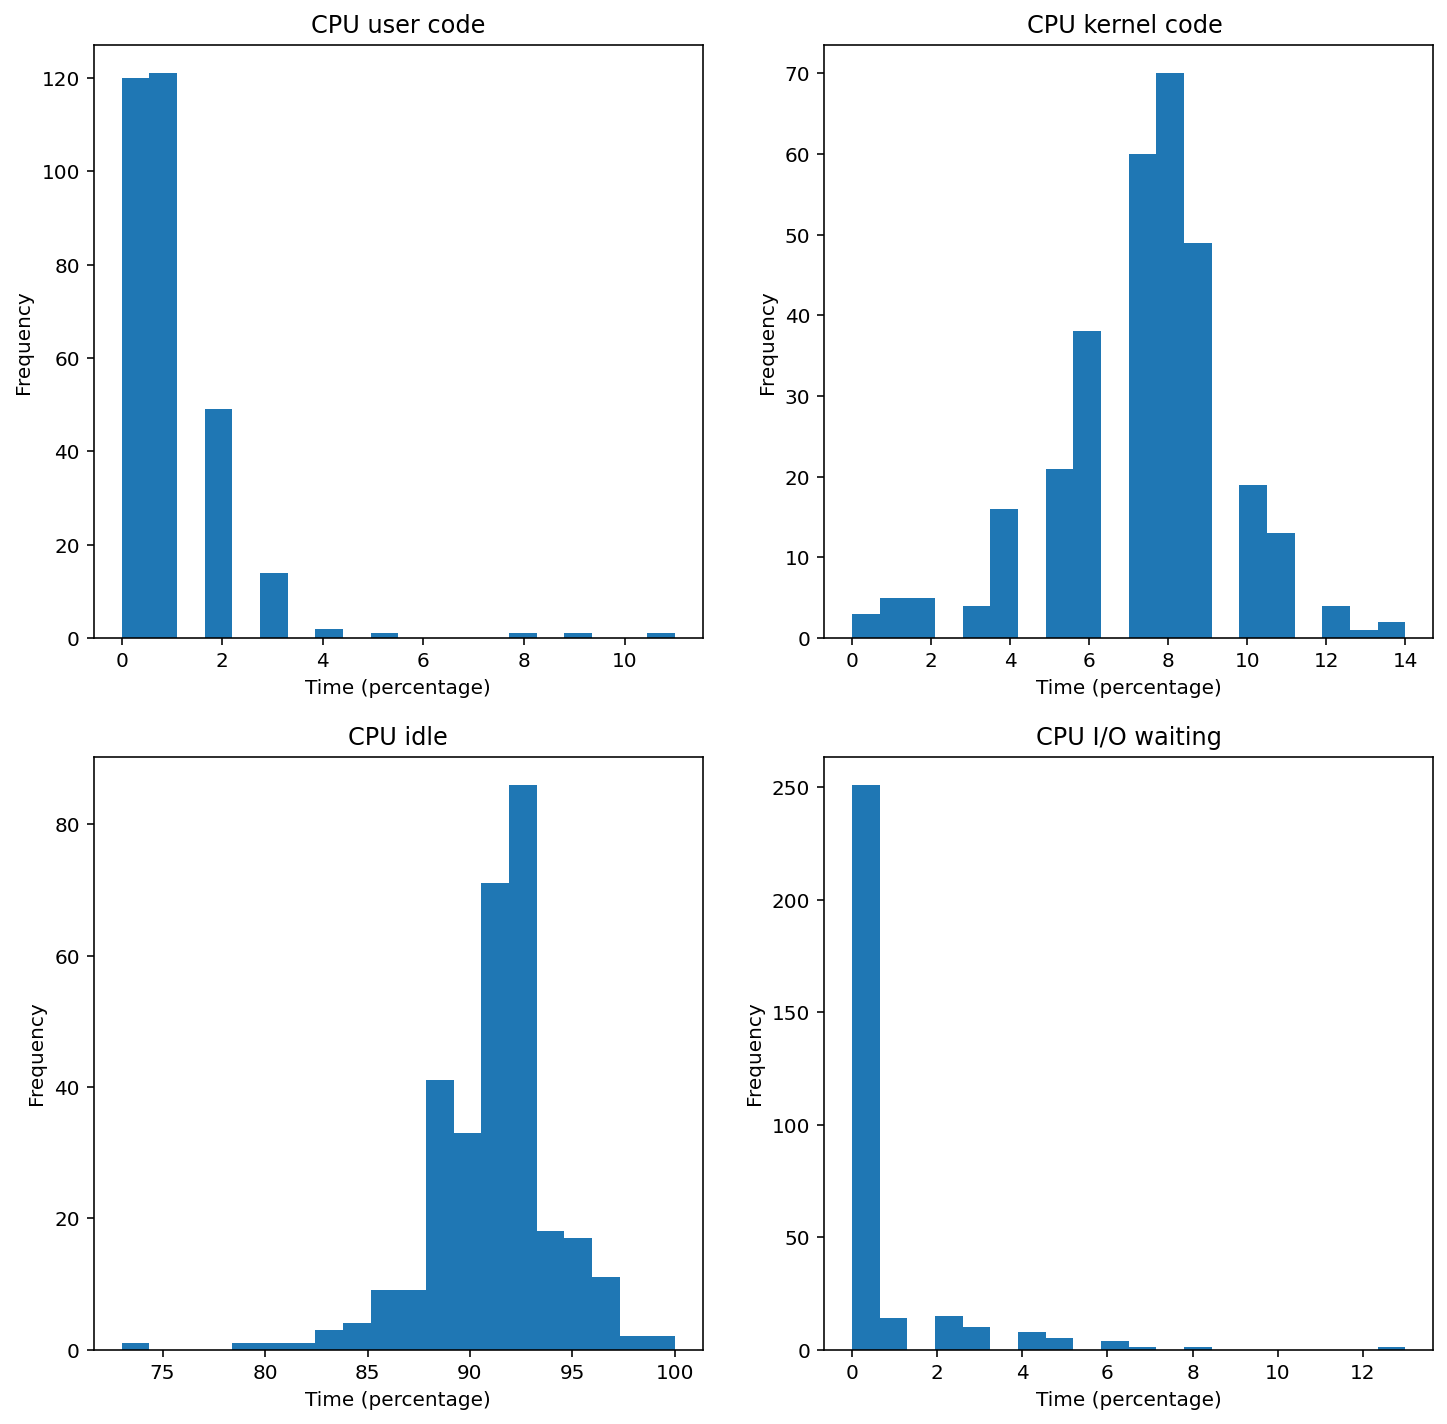

In [50]:
fig = plt.figure(figsize=(12,12))

ax0 = fig.add_subplot(2,2,1)
ax1 = fig.add_subplot(2,2,2)
ax2 = fig.add_subplot(2,2,3)
ax3 = fig.add_subplot(2,2,4)

df_low.cpu_us.plot.hist(bins=20, ax=ax0)
df_low.cpu_sy.plot.hist(bins=20, ax=ax1)
df_low.cpu_id.plot.hist(bins=20, ax=ax2)
df_low.cpu_wa.plot.hist(bins=20, ax=ax3)

ax0.set_title('CPU user code')
ax0.set_xlabel('Time (percentage)')

ax1.set_title('CPU kernel code ')
ax1.set_xlabel('Time (percentage)')

ax2.set_title('CPU idle')
ax2.set_xlabel('Time (percentage)')

ax3.set_title('CPU I/O waiting')
ax3.set_xlabel('Time (percentage)')

plt.show()

## PCA

### Preprocessing

#### Remove constant components

In [51]:
df_const = df_low.loc[:,df_low.columns[df_low.nunique() == 1]]
df_const.head()

,procs_b,memory_swpd,swap_si,swap_so,cpu_st
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


In [52]:
df_low_pre = df_low.loc[:,df_low.columns[df_low.nunique() != 1]]
df_low_pre.head()

,procs_r,memory_free,memory_buff,memory_cache,io_bi,io_bo,system_in,system_cs,cpu_us,cpu_sy,cpu_id,cpu_wa
0,3,753576,47736,611564,689,41,470,435,5,4,87,4
1,0,753568,47740,611504,4,36,402,1212,11,1,87,1
2,0,753568,47740,611504,0,0,82,180,3,0,97,0
3,0,753568,47740,611504,0,0,54,90,1,0,99,0
4,0,753568,47740,611504,0,0,69,157,0,0,100,0


#### Remove perfectly correlated components

In [53]:
df_corr = df_low_pre.corr()
df_corr

,procs_r,memory_free,memory_buff,memory_cache,io_bi,io_bo,system_in,system_cs,cpu_us,cpu_sy,cpu_id,cpu_wa
procs_r,1.000000,0.027545,0.104498,0.159369,0.138898,-0.017596,0.010693,-0.049125,-0.024698,0.004624,-0.004727,0.018686
memory_free,0.027545,1.000000,-0.524101,-0.446395,-0.128184,-0.016909,-0.387694,-0.193256,-0.048989,-0.398911,0.311251,0.046647
memory_buff,0.104498,-0.524101,1.000000,0.977627,-0.089141,-0.019064,0.282466,0.042687,-0.086601,0.271884,-0.120037,-0.102831
memory_cache,0.159369,-0.446395,0.977627,1.000000,-0.086189,-0.039486,0.237868,0.048471,-0.072496,0.227895,-0.091118,-0.103539
io_bi,0.138898,-0.128184,-0.089141,-0.086189,1.000000,0.102473,-0.034213,0.406400,0.377750,0.037637,-0.272941,0.154353
io_bo,-0.017596,-0.016909,-0.019064,-0.039486,0.102473,1.000000,0.024406,0.092094,0.042219,0.027104,-0.148522,0.212930
system_in,0.010693,-0.387694,0.282466,0.237868,-0.034213,0.024406,1.000000,-0.008140,-0.134742,0.780853,-0.540802,-0.004709
system_cs,-0.049125,-0.193256,0.042687,0.048471,0.406400,0.092094,-0.008140,1.000000,0.666783,0.022110,-0.331602,0.053425
cpu_us,-0.024698,-0.048989,-0.086601,-0.072496,0.377750,0.042219,-0.134742,0.666783,1.000000,-0.154480,-0.315396,0.026700
cpu_sy,0.004624,-0.398911,0.271884,0.227895,0.037637,0.027104,0.780853,0.022110,-0.154480,1.000000,-0.741365,0.069184


#### Normalize the components

In [54]:
x = df_low_pre.values

x_scaled = StandardScaler().fit_transform(x)

df_low_pre = pd.DataFrame(data=x_scaled, columns=df_low_pre.columns )
df_low_pre.head()

,procs_r,memory_free,memory_buff,memory_cache,io_bi,io_bo,system_in,system_cs,cpu_us,cpu_sy,cpu_id,cpu_wa
0,3.464196,1.785633,-1.962969,-1.698423,13.782809,0.660724,-2.396267,0.400285,3.263306,-1.444473,-1.360194,2.214415
1,-0.450388,1.783078,-1.951631,-1.849713,0.000195,0.549563,-2.672328,5.921478,8.126886,-2.752516,-1.360194,0.266065
2,-0.450388,1.783078,-1.951631,-1.849713,-0.080288,-0.250792,-3.971437,-1.411690,1.642112,-3.188530,1.952140,-0.383385
3,-0.450388,1.783078,-1.951631,-1.849713,-0.080288,-0.250792,-4.085109,-2.051210,0.020919,-3.188530,2.614607,-0.383385
4,-0.450388,1.783078,-1.951631,-1.849713,-0.080288,-0.250792,-4.024213,-1.575123,-0.789678,-3.188530,2.945841,-0.383385


### Perform PCA

In [55]:
pca = PCA()

princ_comp = pca.fit(df_low_pre.values)

LinAlgError: SVD did not converge

In [ ]:
d = pca.transform(df_low_pre.values)

c = [str(s) for s in range(princ_comp.n_components_)]
c = ['comp ' + s for s in c]

df_low_pca = pd.DataFrame(data=d, columns=c)
df_low_pca.head()

#### Explained variance

In [ ]:
d = {'explained variance': princ_comp.explained_variance_, 'explained variance ratio': princ_comp.explained_variance_ratio_}

df_variance_PCA = pd.DataFrame(data=d)

df_variance_PCA['cumulative explained variance ratio'] = df_variance_PCA.cumsum()['explained variance ratio']
df_variance_PCA.head(10)

In [ ]:
fig = plt.figure(figsize=(15,5))

ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

df_variance_PCA.plot.bar(y=['explained variance ratio'], ax=ax0, legend=False)
df_variance_PCA.plot.bar(y=['cumulative explained variance ratio'], ax=ax1, legend=False)

ax0.tick_params(labelrotation=0)
ax0.set_title('Explained Variance')
ax0.set_xlabel('Principal components')
ax0.set_ylabel('Explained variance ratio')

ax1.tick_params(labelrotation=0)
ax1.set_title('Cumulative Explained Variance')
ax1.set_xlabel('Principal components')
ax1.set_ylabel('Cumulative explained variance ratio')
plt.show()

## Clustering

### Select principal components

In [ ]:
dev_tot = df_low_pre.sub(df_low_pre.mean()).pow(2).sum().sum()

nmin_comp = 5
nmax_comp = 8
n_comp = nmax_comp-nmin_comp+1

nmax_cluster = 50

array_dev_lost = np.zeros(shape=(nmax_cluster,n_comp))
filepath = './array_dev_lost_low.txt'
if(not os.path.isfile(filepath)):
    print('Creating file',filepath, 'this may take a while...\n')
    
    array_dev_lost = np.zeros(shape=(nmax_cluster,n_comp))
    
    for i in tqdmn(range(nmin_comp, nmax_comp+1), desc='outer loop'):

        for j in tqdmn(range(1, nmax_cluster+1), desc='inner loop'):
            df_clustering = df_low_pca.iloc[:,0:i]

            # clustering
            clustering = AgglomerativeClustering(n_clusters=j)
            clustering = clustering.fit(df_clustering.values)

            df_clustering.insert(len(df_clustering.columns), 'cluster', clustering.labels_)

            # deviance PCA
            df_pca = df_low_pca.iloc[:,0:i]
            dev_pca = df_pca.sub(df_pca.mean()).pow(2).sum().sum()

            # deviance clustering 
            n_elem = df_clustering.groupby('cluster').count().values[:,0]
            centroids = df_clustering.groupby('cluster').mean()

            # intra-cluster deviance
            arr = np.zeros(shape=(j,1))
            for k in range(j):
                elem_k = df_clustering.loc[df_clustering['cluster'] == k].drop(columns='cluster')
                arr[k] = elem_k.sub(centroids.loc[k,:]).pow(2).sum().sum()
            dev_intra = arr.sum()

            # inter-cluster deviance
            dev_inter = centroids.sub(df_clustering.mean()).pow(2).mul(n_elem, axis=0).sum().sum()
            dev_inter

            # deviance lost
            dev_pca_ratio = dev_pca/dev_tot
            dev_inter_ratio = dev_inter/dev_pca
            dev_lost = 1 - dev_inter_ratio * dev_pca_ratio

            array_dev_lost[j-1][i-n_comp-1] = dev_lost
            
#         print(array_dev_lost)
    with open (filepath, 'wb') as fp:
        pickle.dump(array_dev_lost, fp)

else:
    print('File already exists!\n')
    with open (filepath, 'rb') as fp:
        array_dev_lost = pickle.load(fp)
        
        
# array_dev_lost

In [ ]:
x = np.arange(1,nmax_cluster+1)

plt.figure(figsize=(7,5))

for i in range(nmin_comp,nmax_comp+1):
    y_dev_lost = array_dev_lost[:,i-n_comp-1]
    plt.plot(x, y_dev_lost)
    
c = [str(s) for s in range(nmin_comp,nmax_comp+1)]
c = [s + ' comp' for s in c]
    
plt.title('Deviance lost')
plt.ylabel('Deviance lost ratio')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(0,nmax_cluster+1,2))
plt.yticks(np.linspace(0,y_dev_lost.max(),20))
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.legend(c)
plt.show()


In [ ]:
n_comp = 6
df_low_cl = df_low_pca.iloc[:,0:n_comp]
df_low_cl.head()

### Perform clustering

In [ ]:
n_clusters = 16

clustering = AgglomerativeClustering(n_clusters=n_clusters)
clustering = clustering.fit(df_low_cl.values)

In [ ]:
df_low_clu = df_low
df_low_clu.loc[:,'cluster'] = clustering.labels_
df_low_clu.head()

In [ ]:
df_low_clu.groupby(by='cluster').count().procs_r.plot.bar(figsize=(6,6))
plt.xticks(rotation=0)
plt.show()

In [ ]:
# altri grafici?

## Synthetic workload

In [ ]:
# Correggere questa sezione

In [ ]:
# df_low_clu.groupby(by=['cluster','threadType','label']).count().max(level=[0,1,2])

In [ ]:
# df_synth = df_low_clu.groupby('cluster').apply(lambda x: x.sample())
# df_synth = df_synth.reset_index(level=0, col_level=2 , drop=True)
# df_synth